In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import permutations
from collections import defaultdict
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [2]:
global time_tick
global grow_count
global birth_count
global bump_count
global death_count
global trends

In [3]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [4]:
def extract_tribe(cells, cell_weights, labels, node_n = 225):
    db = DBSCAN().fit(cell_weights)
    flags = []
    for k in labels:
        flags = [flags, [j for j, x in enumerate(db.labels_ == k) if x]]
    print(flags)
    next_cells = cells[flags,:]  
    next_weights = cell_weights[flags,:]
    return(next_cells, next_weights, db)

In [5]:
def slime(x = None,
          y = None,
          start_pop = 25,
          fig_size = [5,5],
          border = 40,
          sight = 5,
          board_size = 100,
          max_hp = 6,
          baby_hp = 3,
          log = False,
          frames=500,
          interval=50,
          mode='once'):
    
    global time_tick
    global grow_count
    global birth_count
    global bump_count
    global death_count
    global trends
    global cells
    global cell_weights
    global cell_name
    global killed
    
    time_tick = 0
    grow_count = 0
    birth_count = 0
    bump_count = 0
    death_count = 0
    trends = np.array([0,0,0,0,0])
    killed = np.array([], dtype = int)
    
    cell_name = 1
    
    def sig_func(x,y):
        return(1/(1+np.exp(-(np.dot(x,y)))))

    # Function to build the initial cell list.  NN is built around sight/input of 5, movement/output of 3.
    if(x == None):
        cells = np.zeros((start_pop,4))
        cell_weights = np.zeros((start_pop,(sight*sight*3*3)))
        for i in range(0,start_pop):
            cells[i,:] = [cell_name, np.random.choice(range(border, board_size-border)),
                        np.random.choice(range(border, board_size-border)), baby_hp]
            cell_weights[i,:] = 2*np.random.random((sight*sight*3*3))-1
            cell_name += 1
    else:
        cells = x
        cell_weights = y

    # Create the board.
    X = np.zeros(shape=(board_size,board_size))
    
    # initialization function: plot the background of each frame
    def init():
        im.set_data(X)
        return (im,)
    
    # Get the coodinates for the input.
    L = [0, 0, 1, 1, -1, -1, 2, 2, -2, -2]
    keep = [0,0]
    for comb in permutations(L, r=2):
        keep = np.vstack((keep, comb))
    
    # Setup plotting.
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='hot', interpolation='nearest')
    im.set_clim(0, 8)
        
    def animate(i):
        
        global time_tick
        global grow_count
        global birth_count
        global bump_count
        global death_count
        global trends
        global cells
        global cell_weights
        global cell_name
        global total_pop
        global killed
                
        # Take turns through the cell list.
        time_tick += 1
        im.set_data(animate.X)
        for i in range(0, len(cells)):
            if(i in killed):
                pass
            else:
                # Input.
                test_in = []
                for perm in np.mod(cells[i,1:3] + np.unique(keep,axis=0), board_size):
                    test_in = np.append(test_in, X[int(perm[0]), int(perm[1])])
                # Output.
                test_out = sig_func(test_in,cell_weights[i,:].reshape((sight*sight, 3*3)))
                d = test_out.argmin()

                # Stay and Grow.
                if(d==4):               
                    if(cells[i,3] < max_hp):
                        cells[i,3] += 1
                        grow_count += 1
                        if(log == True):
                            print("{0} grew to size {1}.".format(cells[i,0], cells[i,3]))

                # Move.
                else:
                    if(d==0):
                        new_coord = [-1,1]
                    if(d==1):
                        new_coord = [0,1]
                    if(d==2):
                        new_coord = [1,1]
                    if(d==3):
                        new_coord = [-1,0]
                    if(d==5):
                        new_coord = [1,0]
                    if(d==6):
                        new_coord = [-1,-1]
                    if(d==7):
                        new_coord = [0,-1]
                    if(d==8):
                        new_coord = [1,-1]

                    # If it is clear to move.
                    destination = np.mod(np.add(cells[i,1:3].astype(float), new_coord), board_size)
                    if(X[int(destination[0]), int(destination[1])] == 0):
                        # Clear where it was if not splitting.
                        if(cells[i,3] < max_hp):
                            last_spot = cells[i,1:3]
                            X[int(last_spot[0]),int(last_spot[1])] = 0         
                        # Handle splitting, don't clear.
                        if(cells[i,3] >= max_hp):
                            # Half its size.
                            cells[i,3] = baby_hp
                            # Give the baby attributes and mutate the NN.
                            baby_name = cell_name
                            cell_name += 1
                            a = [baby_name,np.random.choice(range(100)),
                                 np.random.choice(range(board_size)),baby_hp]
                            b = 2*np.random.random((sight*sight*3*3))-1
                            b[np.random.choice(sight*sight*3*3)] == 2*np.random.random(1)-1
                            cells = np.vstack((cells, a)) 
                            cell_weights = np.vstack((cell_weights, b))
                            X[int(cells[i,1]), int(cells[i,2])] = abs(sum(b))
                            birth_count += 1
                            if(log == True):
                                print("{0} underwent mitosis.  Gave birth to {1}.".format(cells[i,0], baby_name))    
                        # Give new coordinate and fill it in.
                        cells[i,1:3] = destination
                        X[int(destination[0]), int(destination[1])] = abs(sum(cell_weights[i,:]))

                    else:
                        # It gets bumped.

                        x = [i for i, j in enumerate(cells[:,1]) if j == destination[0]]
                        y = [i for i, j in enumerate(cells[:,2]) if j == destination[1]]
                        z = intersection(x,y)
                    
                        if(cells[i,3] > cells[z,3]):
                            cells[i,3] += 1
                            cells[z,3] -= 1
                        if(cells[i,3] == cells[z,3]):
                            cells[i,3] -= 1
                            cells[z,3] -= 1
                        if(cells[i,3] < cells[z,3]):
                            cells[i,3] -= 1
                            cells[z,3] += 1  

                        bump_count += 1   
                        if(log == True):
                            print("{0} was injured to size {1}!".format(cells[i,0], cells[i,3]))
                        # Handle death.
                        if(cells[i,3] < 1):
                            # Clear where it was and delete from list.
                            last_spot = cells[i,1:3]
                            X[int(last_spot[0]),int(last_spot[1])] = 0
                            killed = np.append(killed,i)
                            death_count += 1
                            if(log == True):
                                print("{0} died!.".format(cells[i,0]))
                        try:
                            if(cells[z,3] < 1):
                                # Clear where it was and delete from list.
                                last_spot = cells[z,1:3]
                                X[int(last_spot[0]),int(last_spot[1])] = 0
                                killed = np.append(killed,z)
                                death_count += 1
                                if(log == True):
                                    print("{0} died!.".format(cells[z,0]))
                        except:
                            pass

        current = np.array([time_tick, grow_count, birth_count, bump_count, death_count])                
        trends = np.vstack((trends, current))                
        return (im,)
        
    animate.X = X
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=interval)
    
    return (display_animation(anim, default_mode=mode), cells, cell_weights, trends, killed)


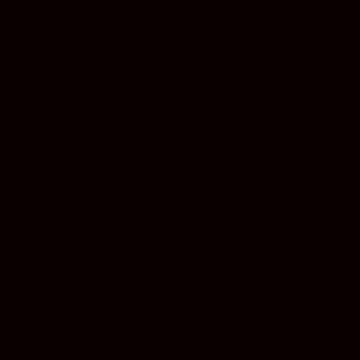
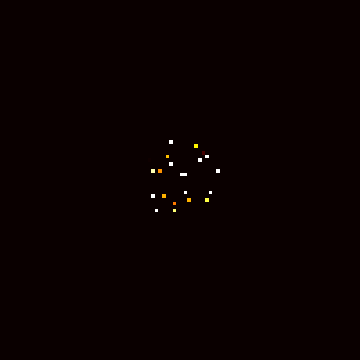
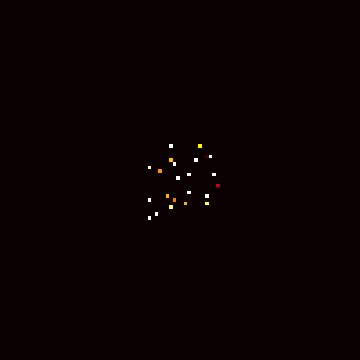
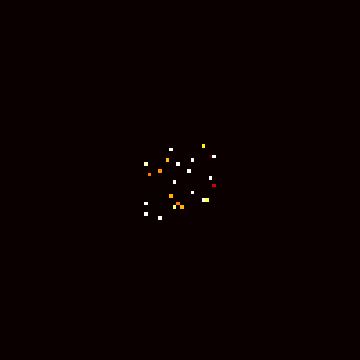
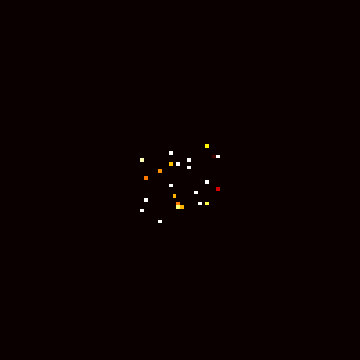
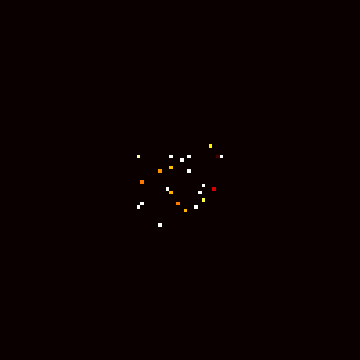
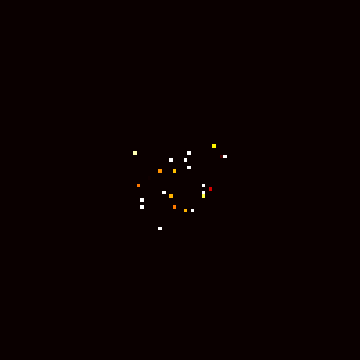
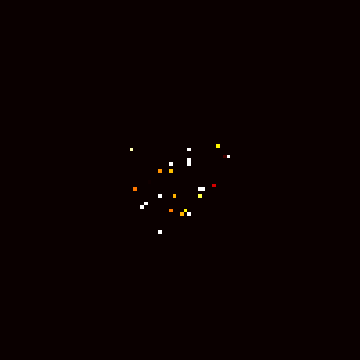
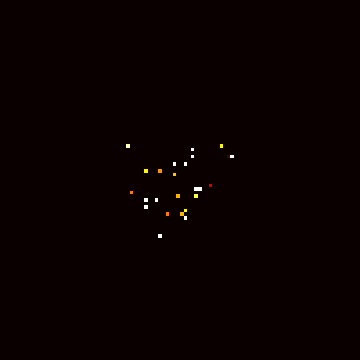
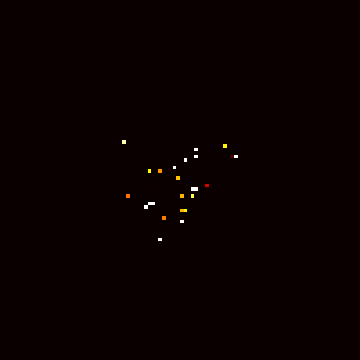
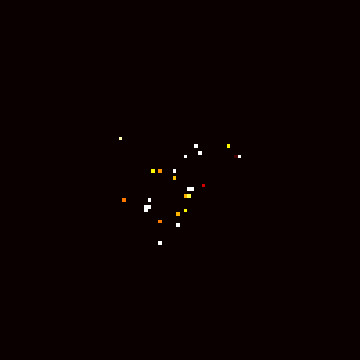
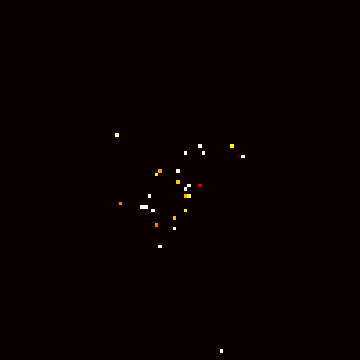
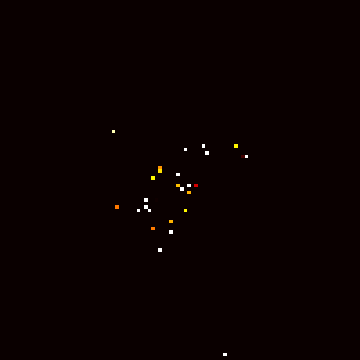
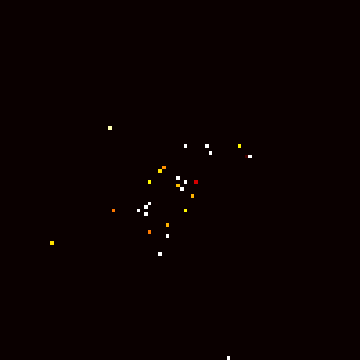
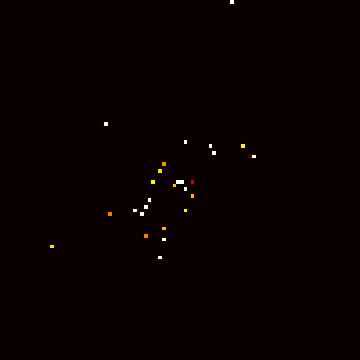
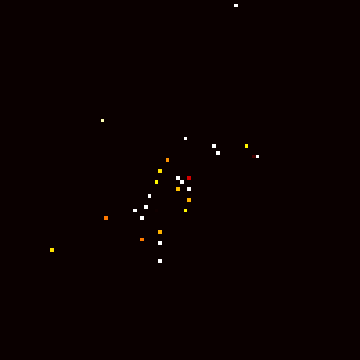
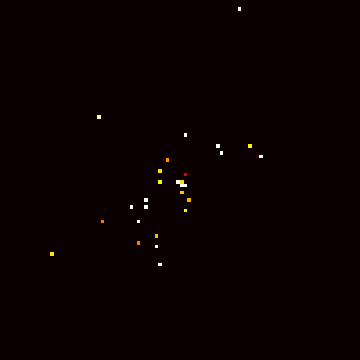
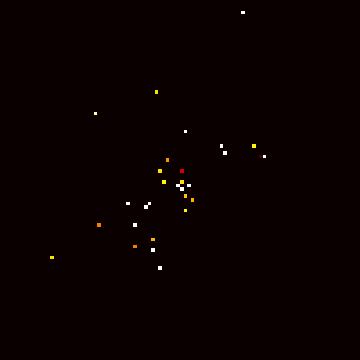
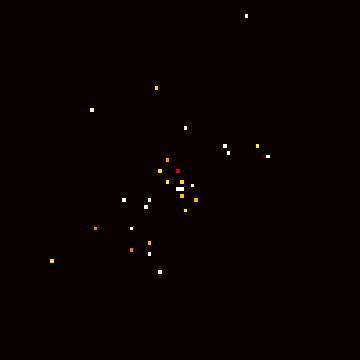
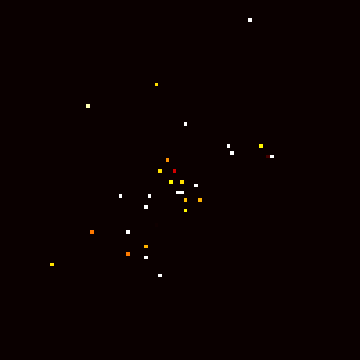
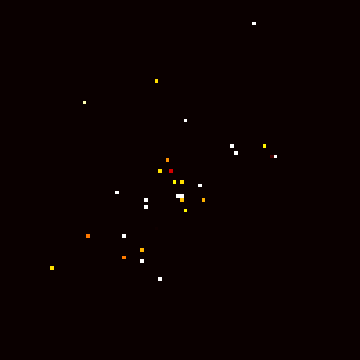
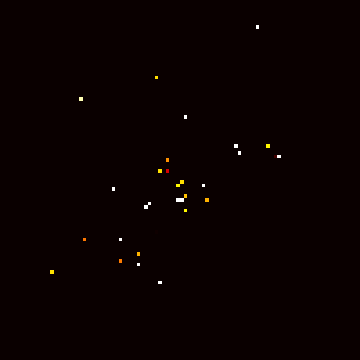
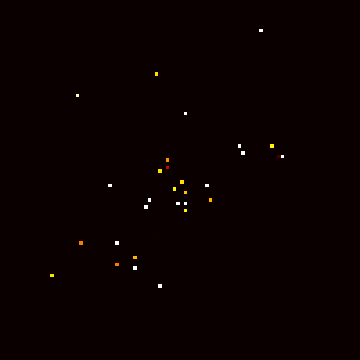
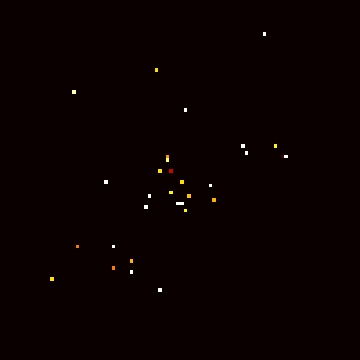
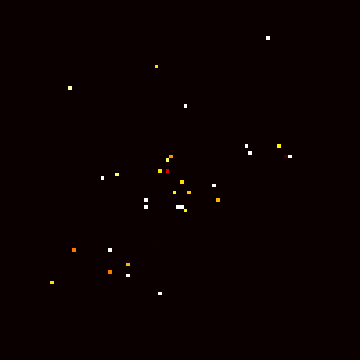
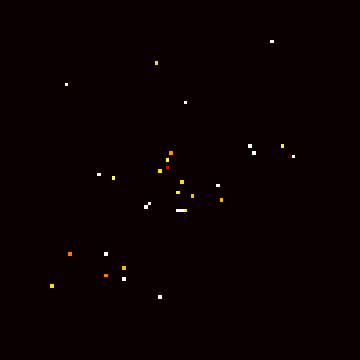
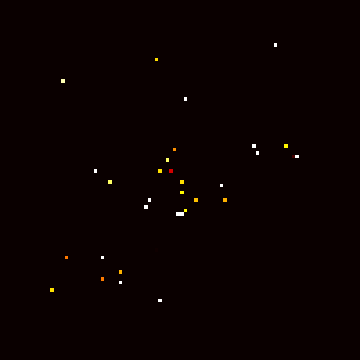
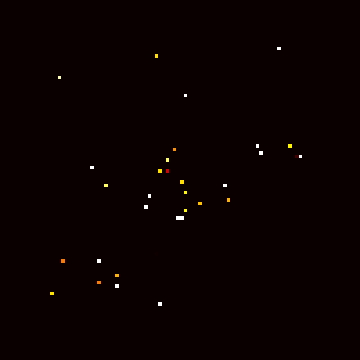
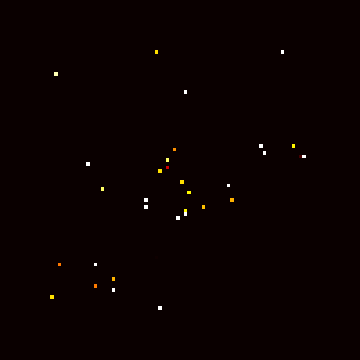
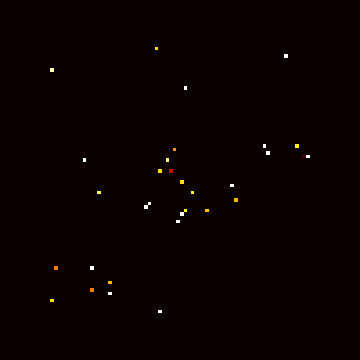
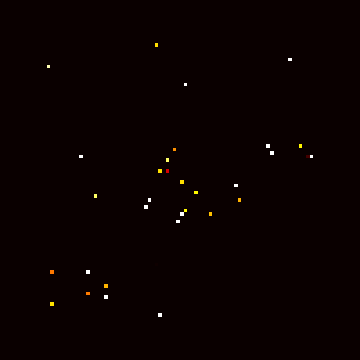
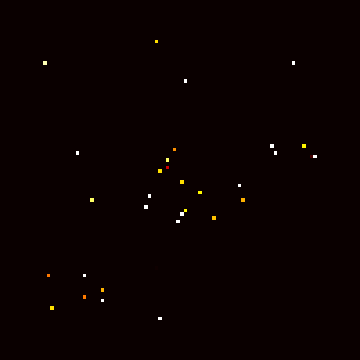
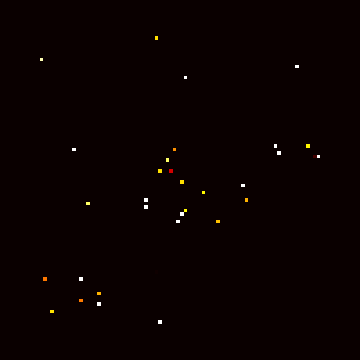
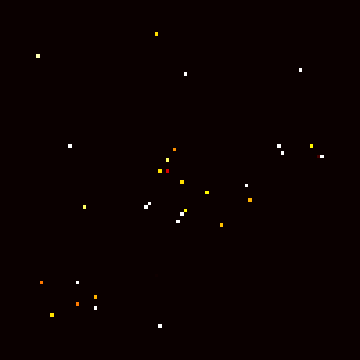
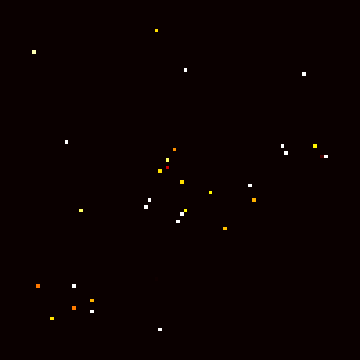
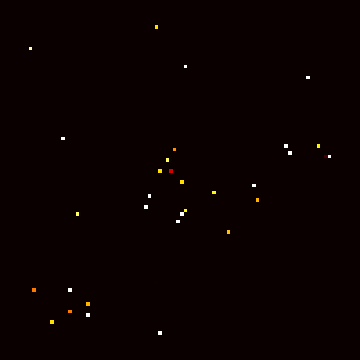
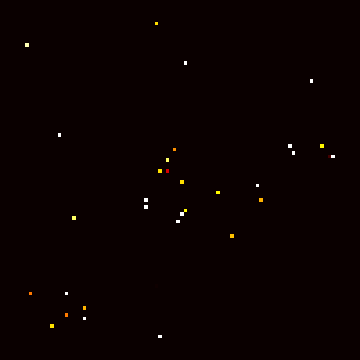
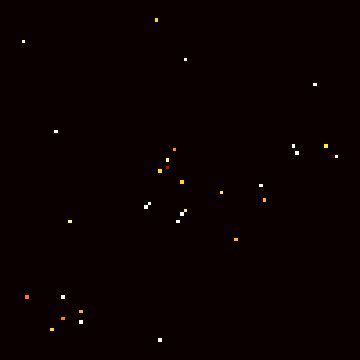
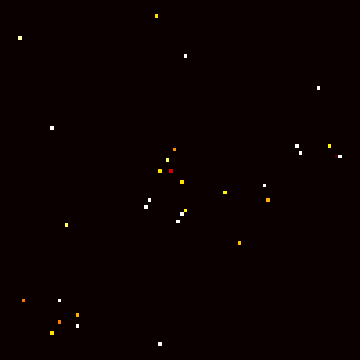
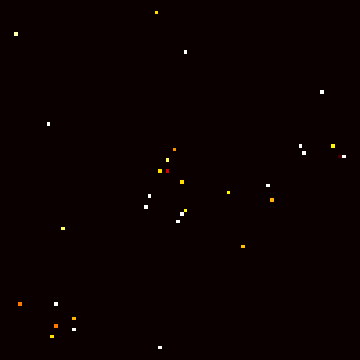
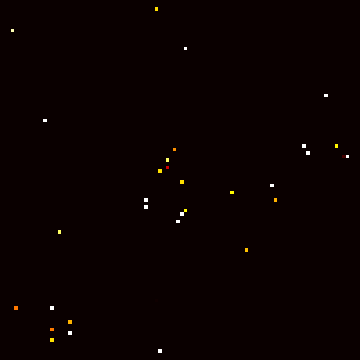
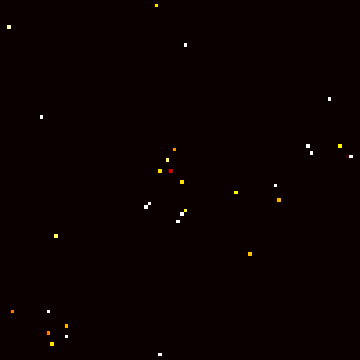
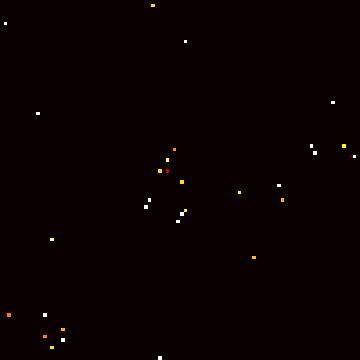
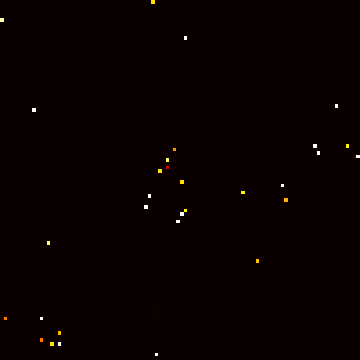
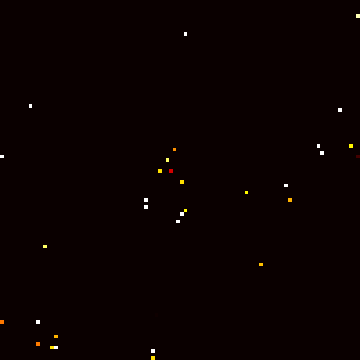
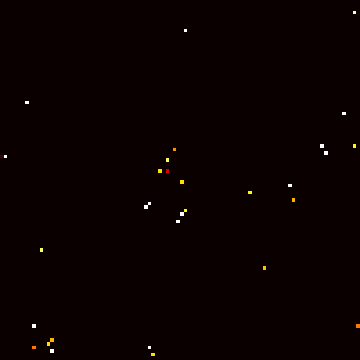
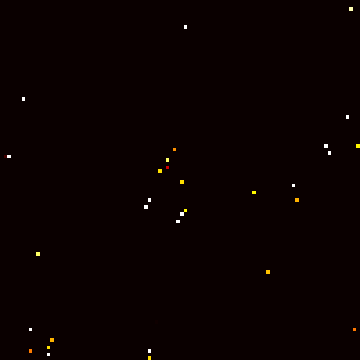
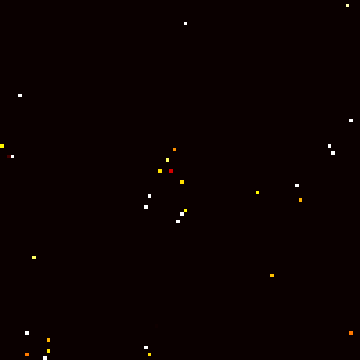
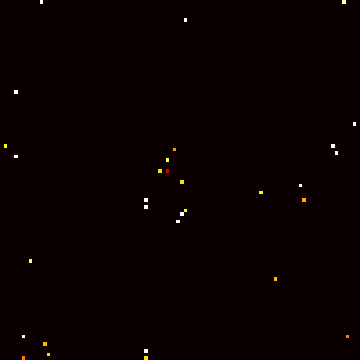
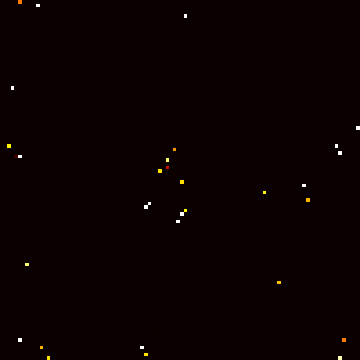
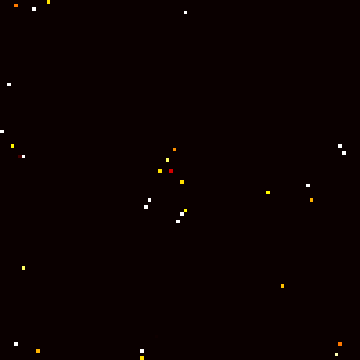
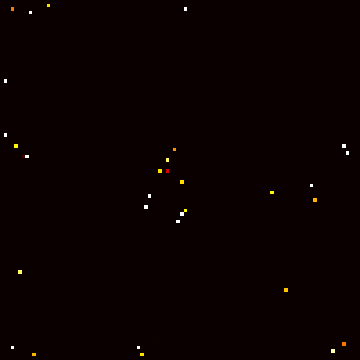
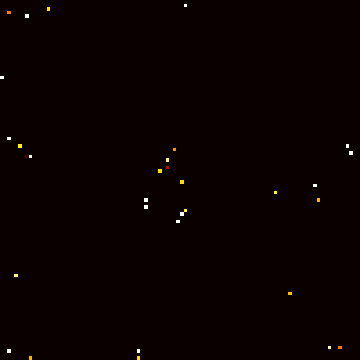
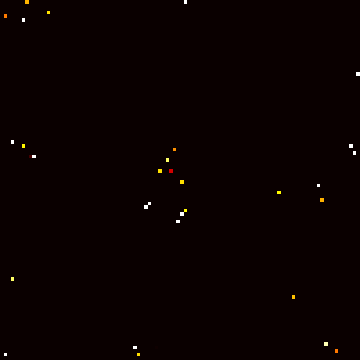
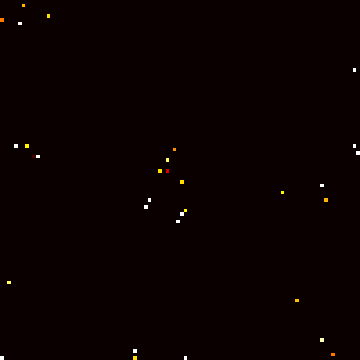
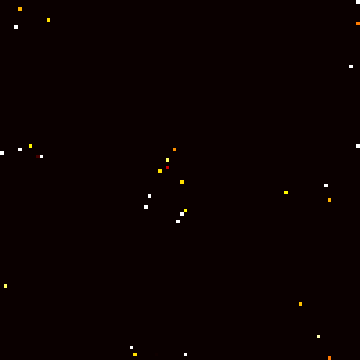
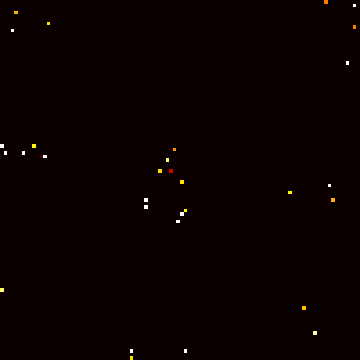
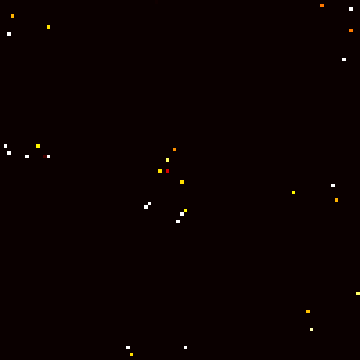
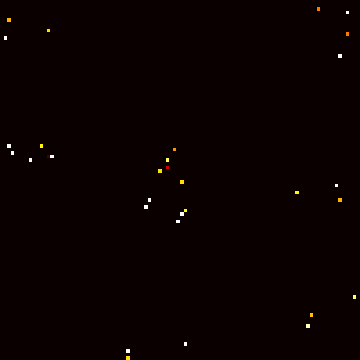
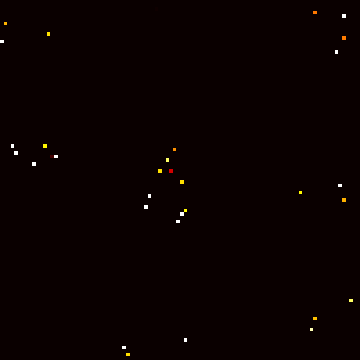
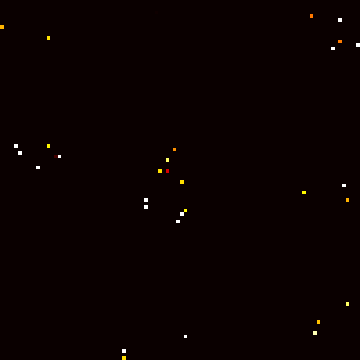
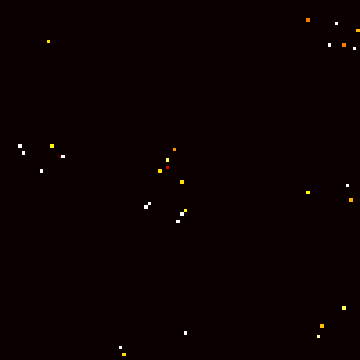
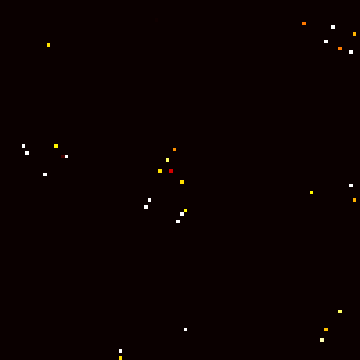
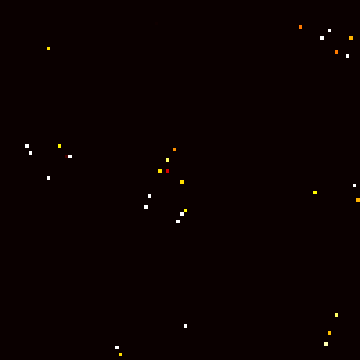
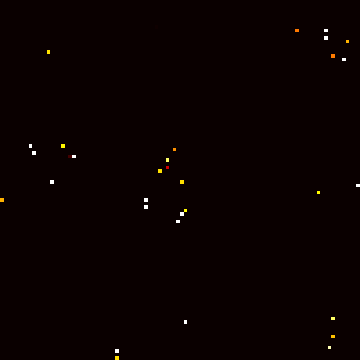
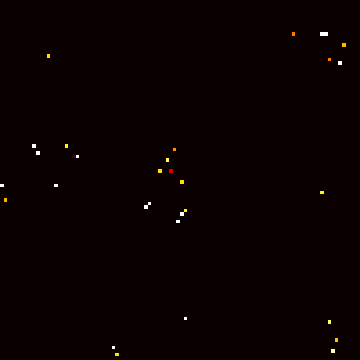
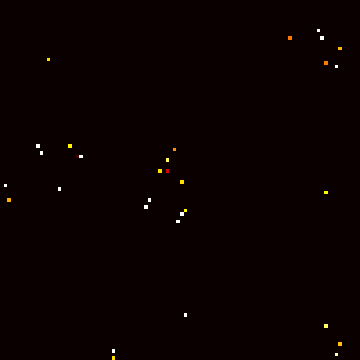
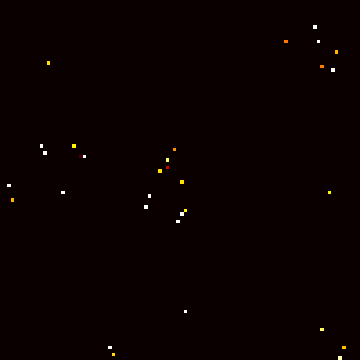
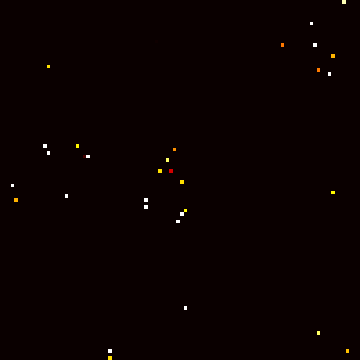
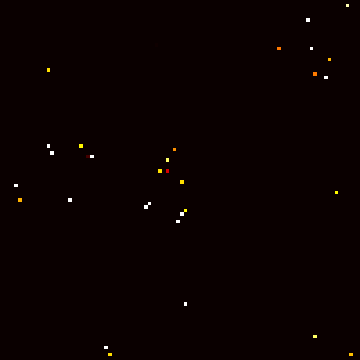
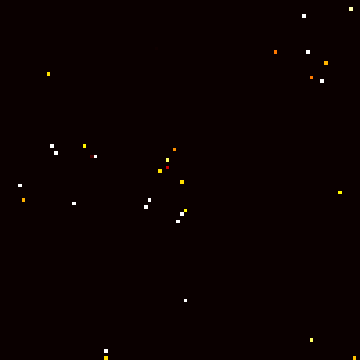
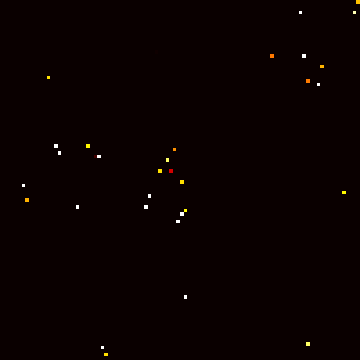
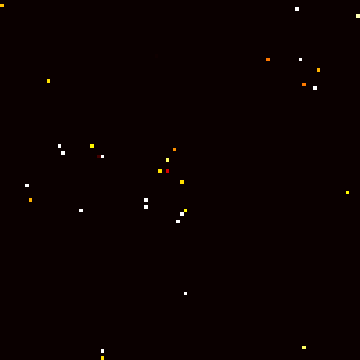
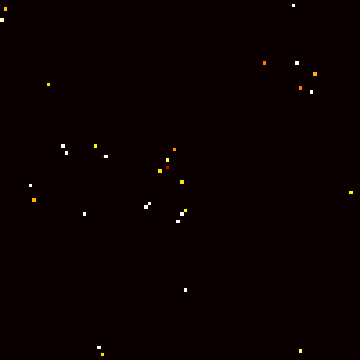
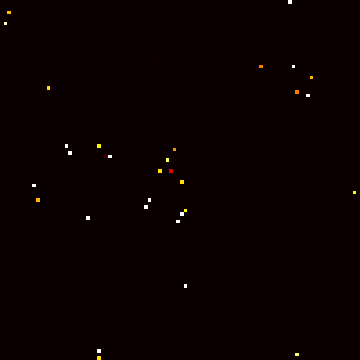
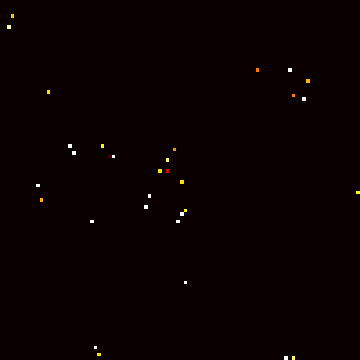
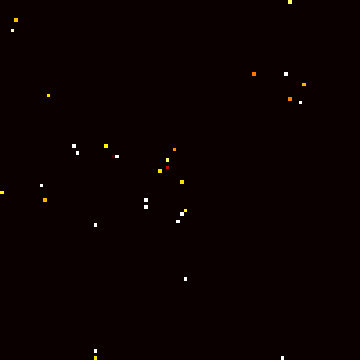
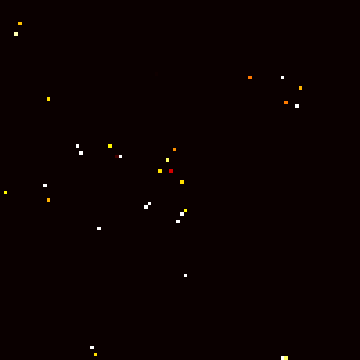
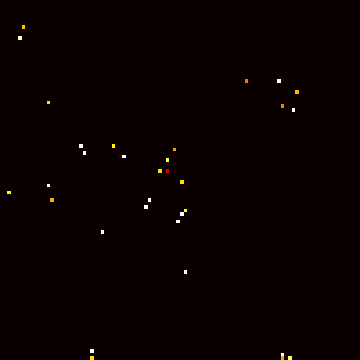
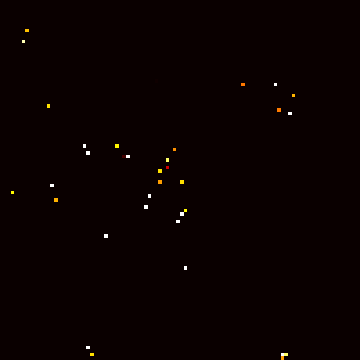
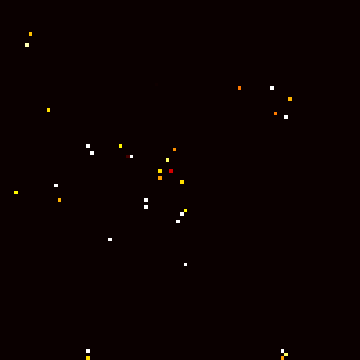
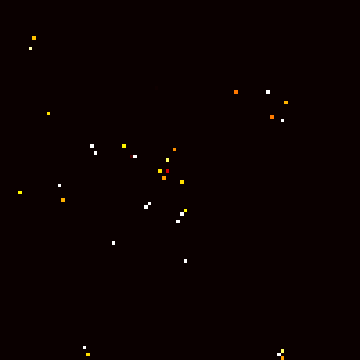
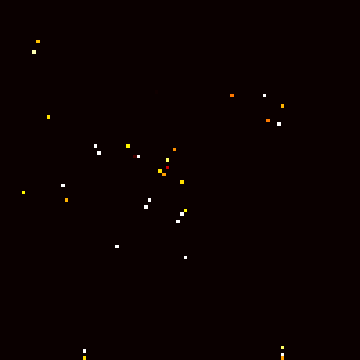
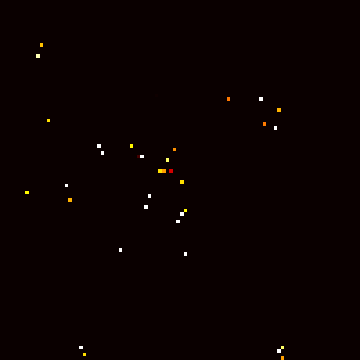
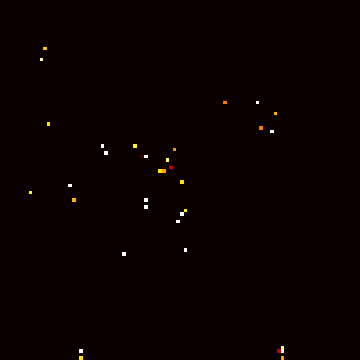
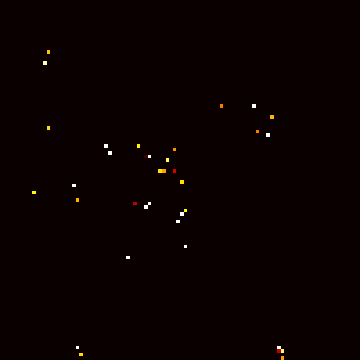
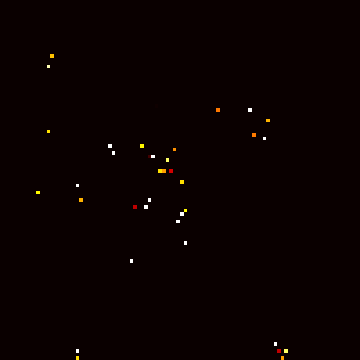
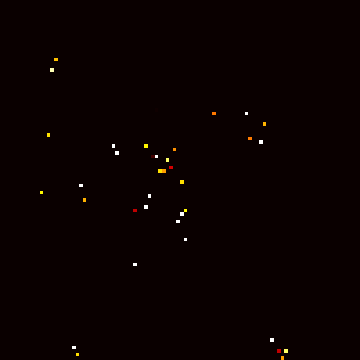
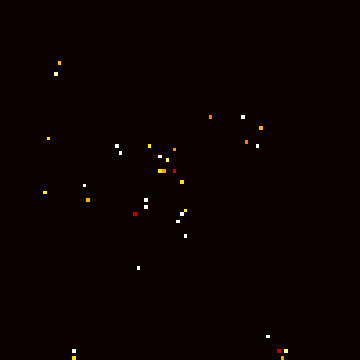
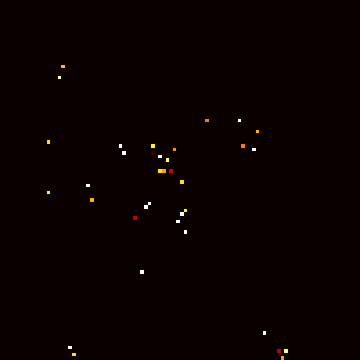
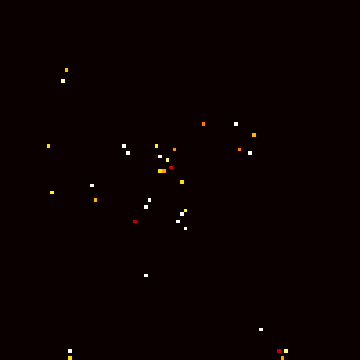
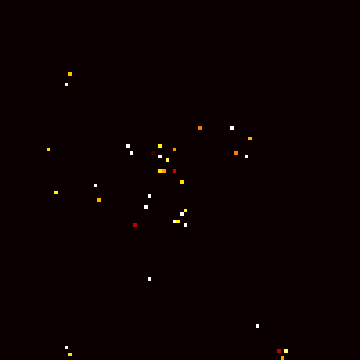
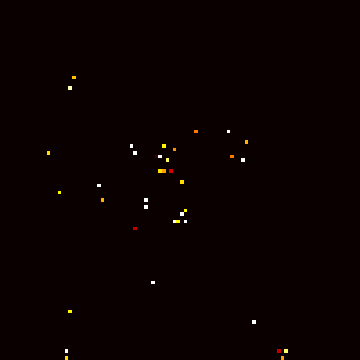
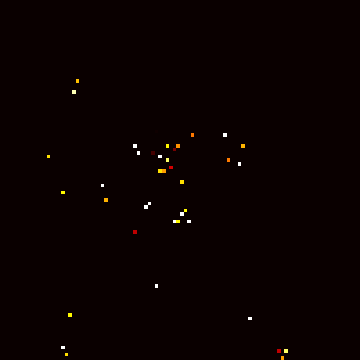
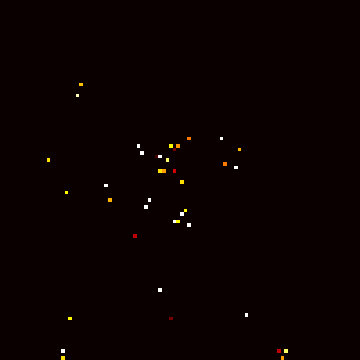
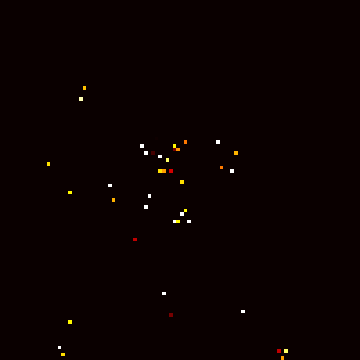
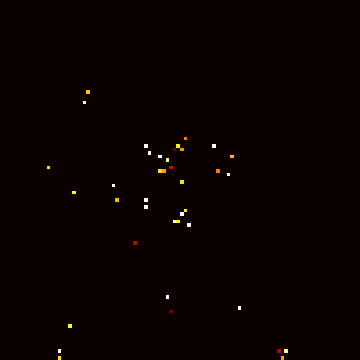
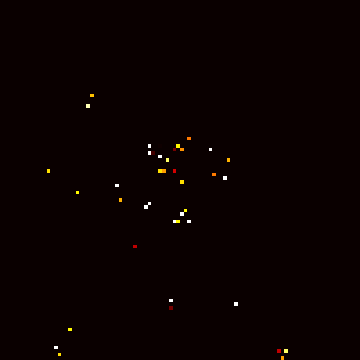
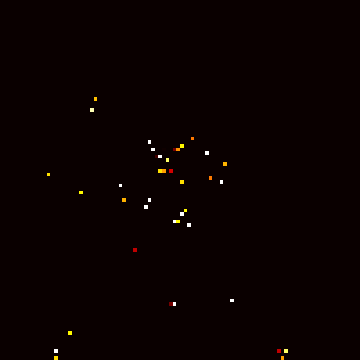
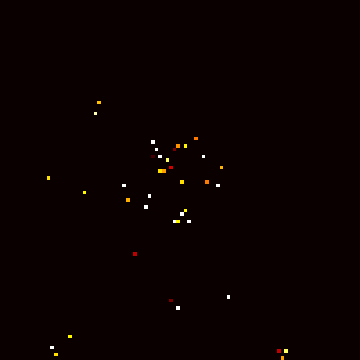
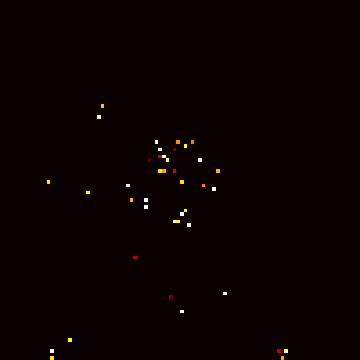
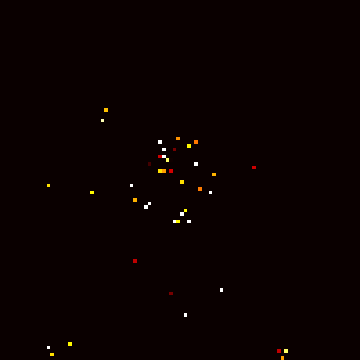
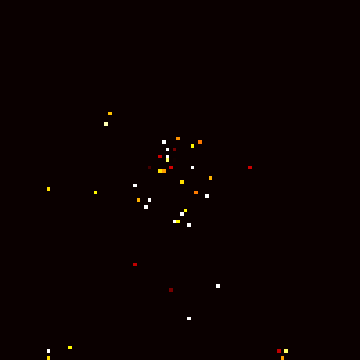
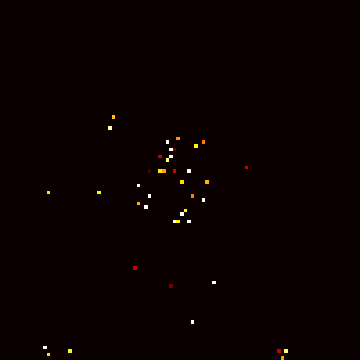
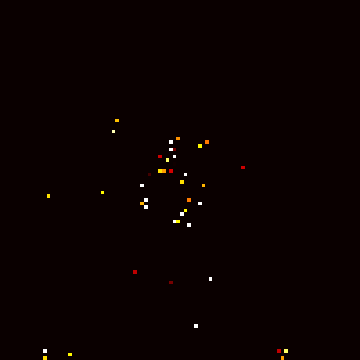
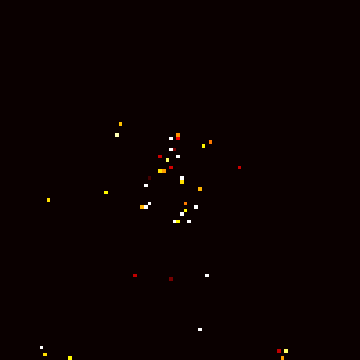
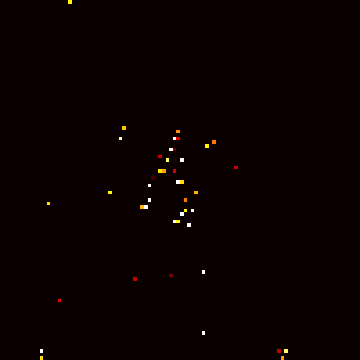
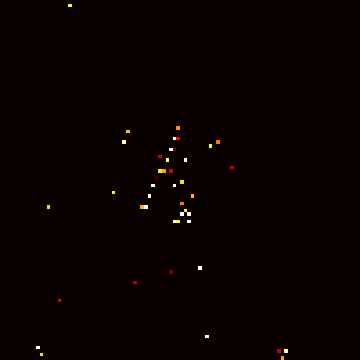
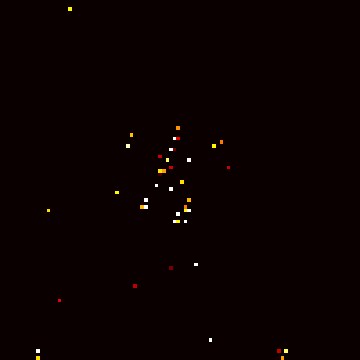
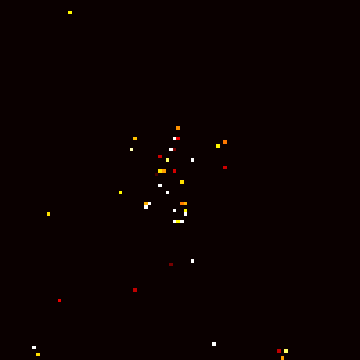
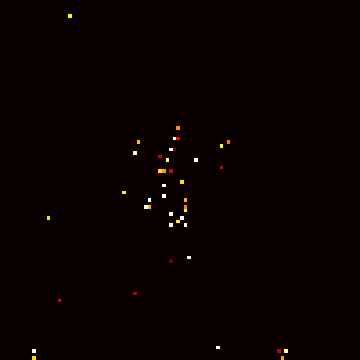
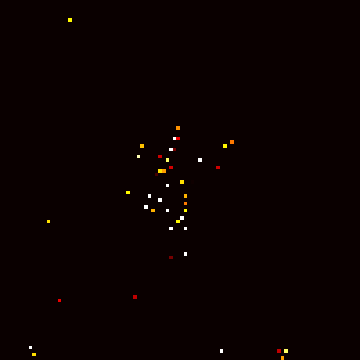
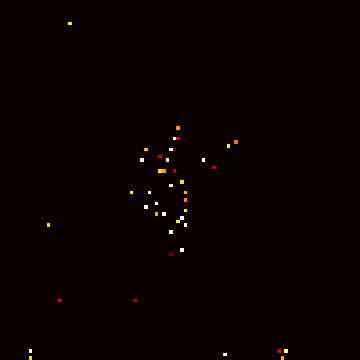
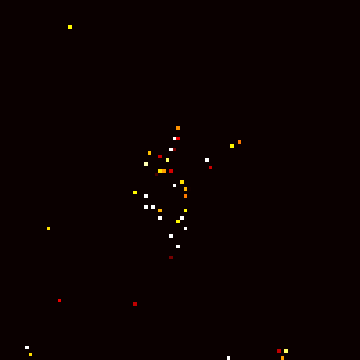
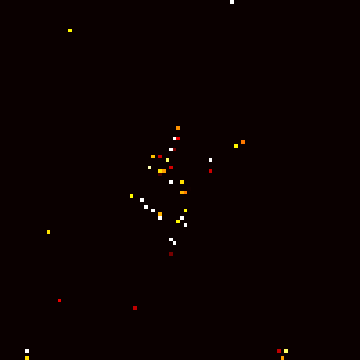
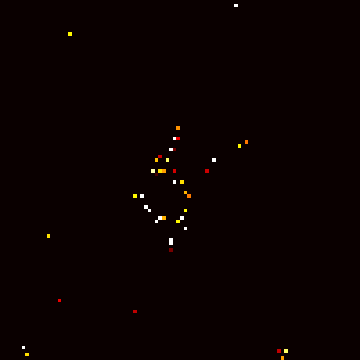
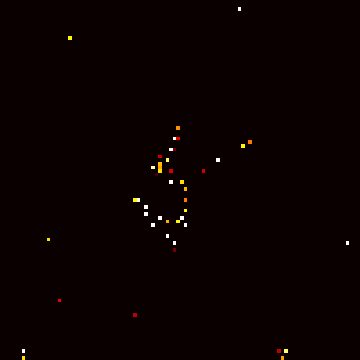
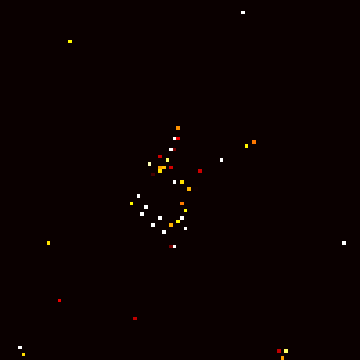
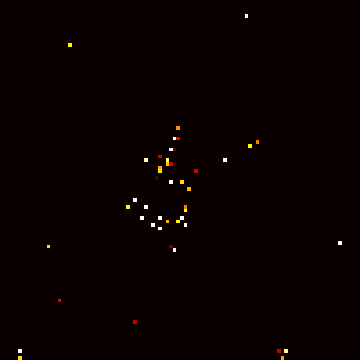
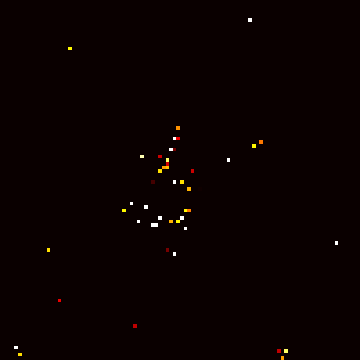
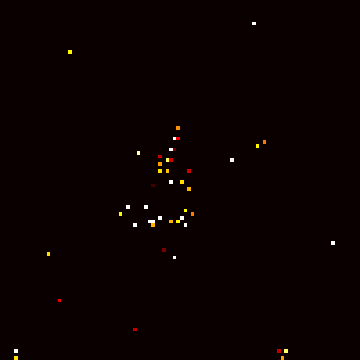
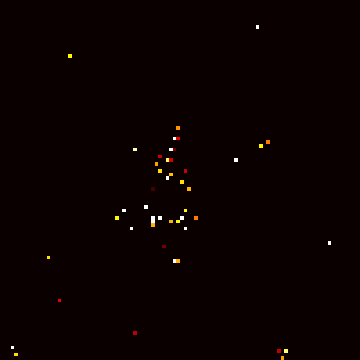
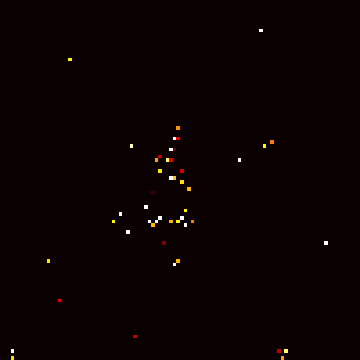
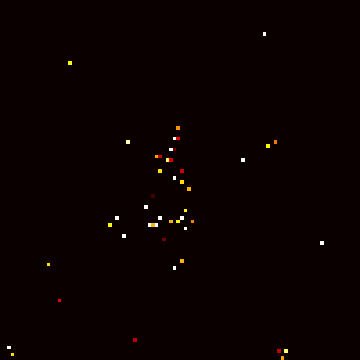
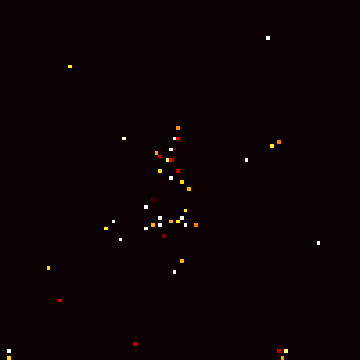
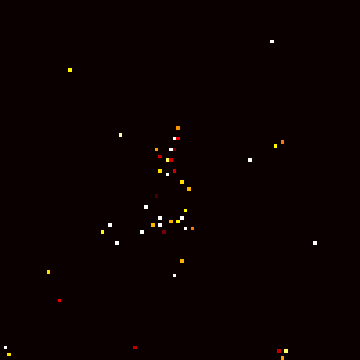
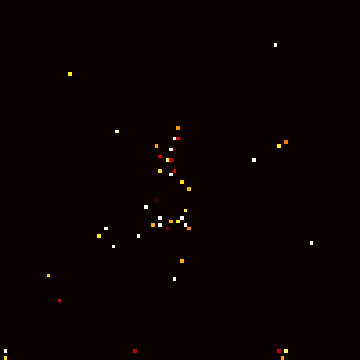
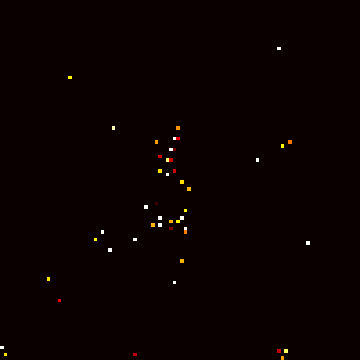
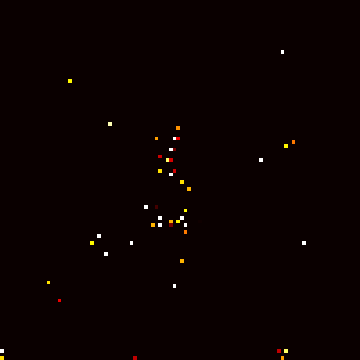
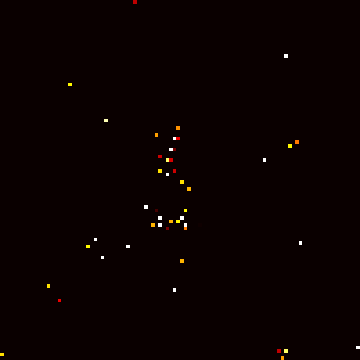
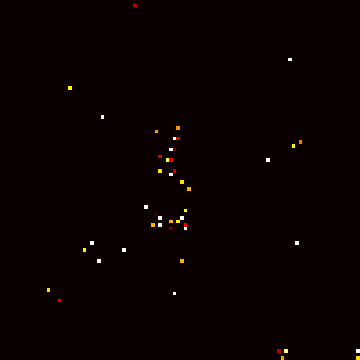
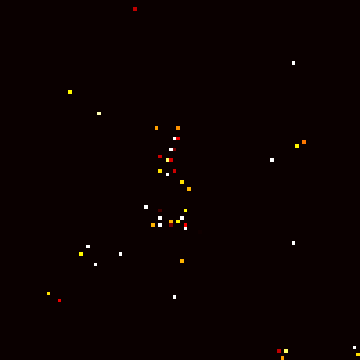
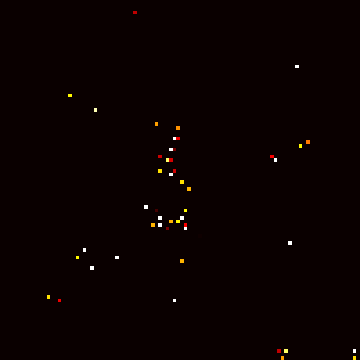
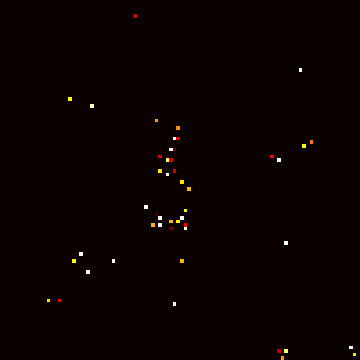
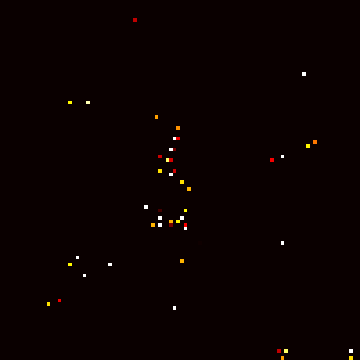
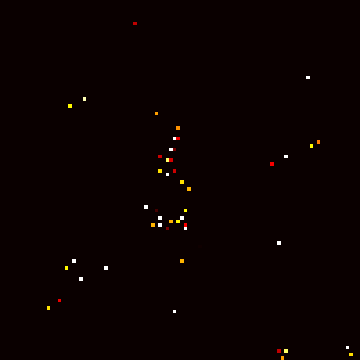
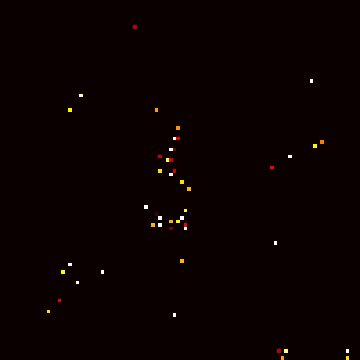
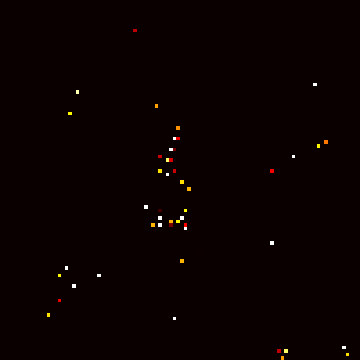
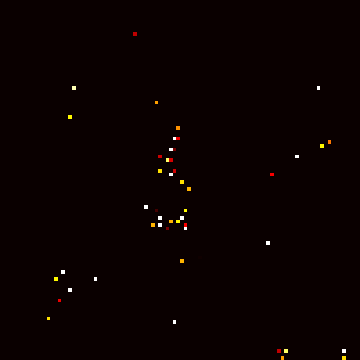
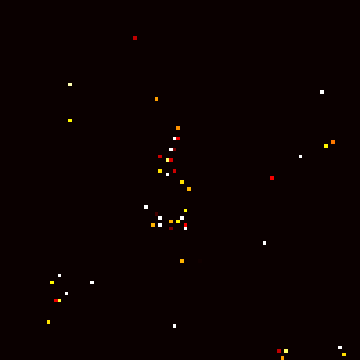
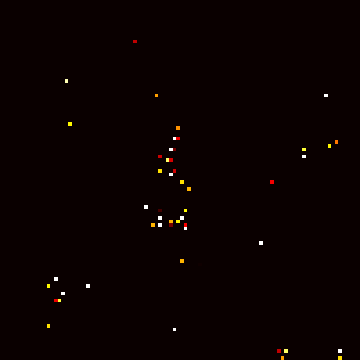
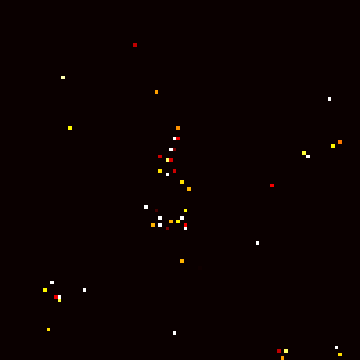
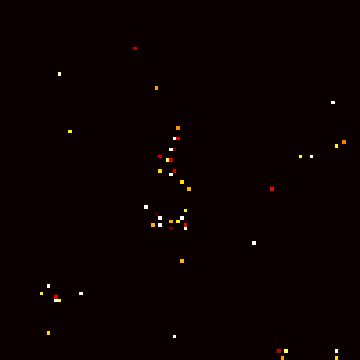
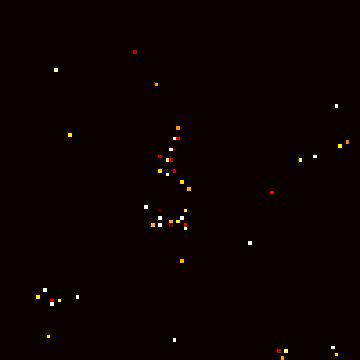
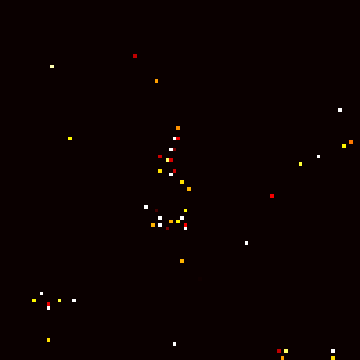
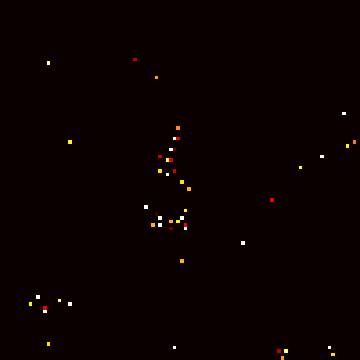
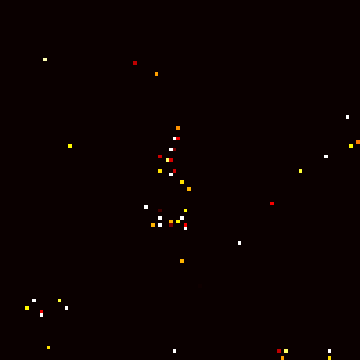
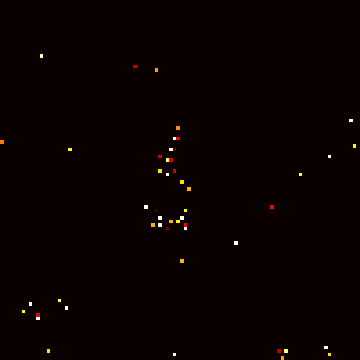
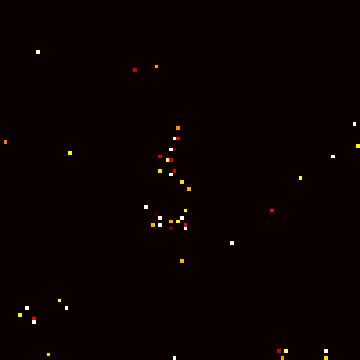
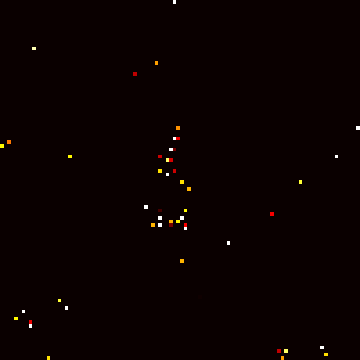
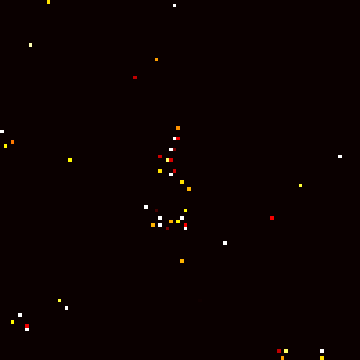
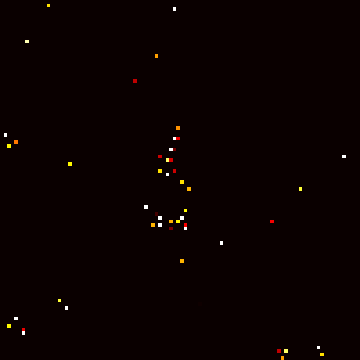
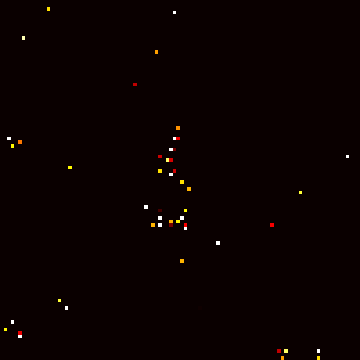
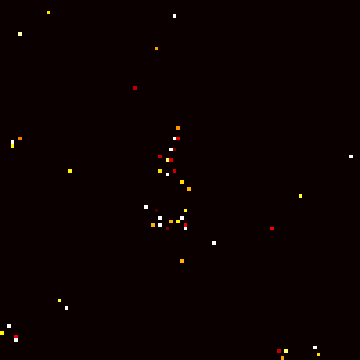
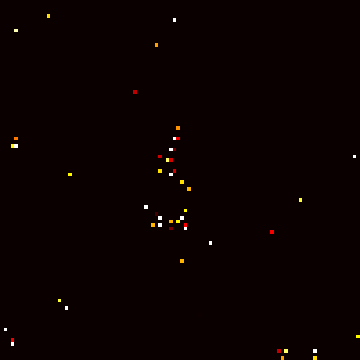
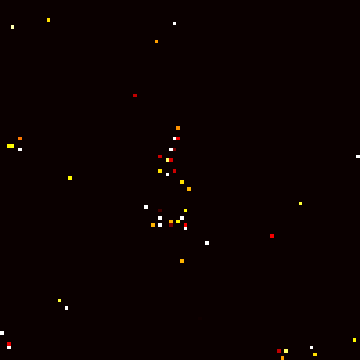
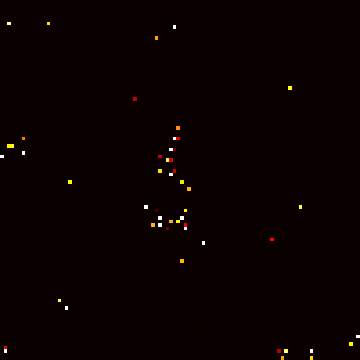
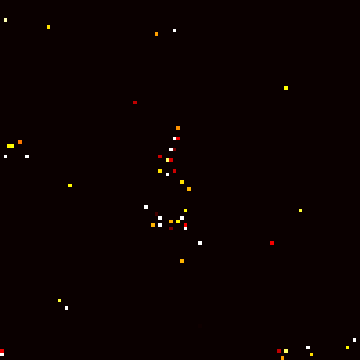
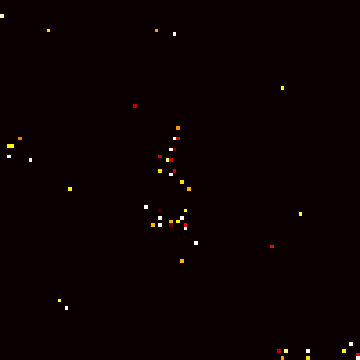
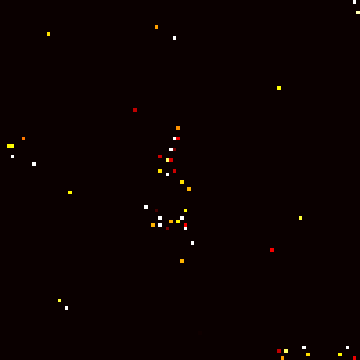
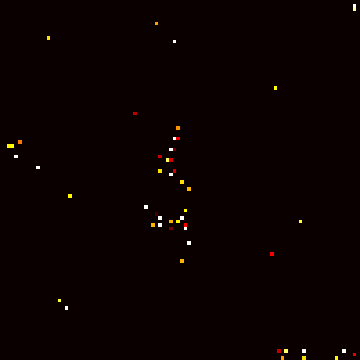
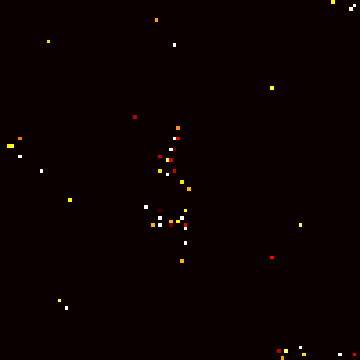
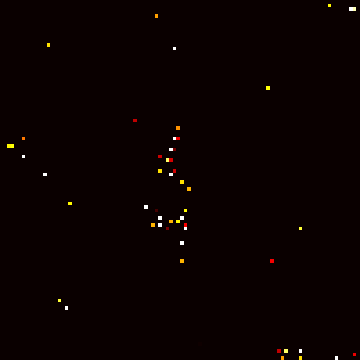
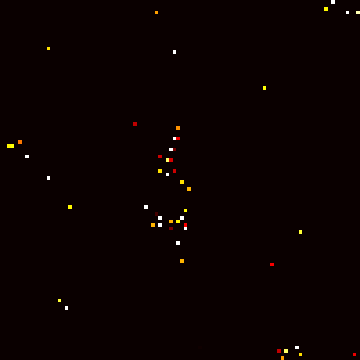
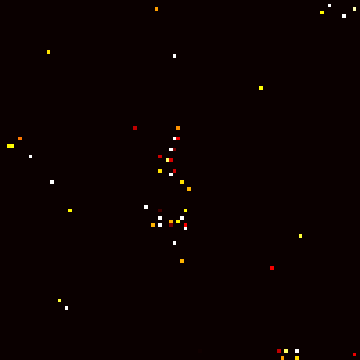
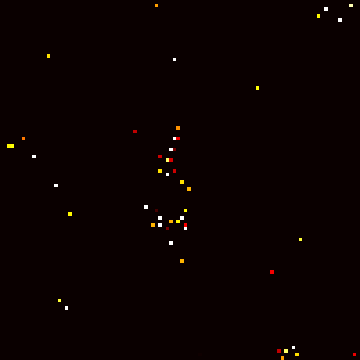
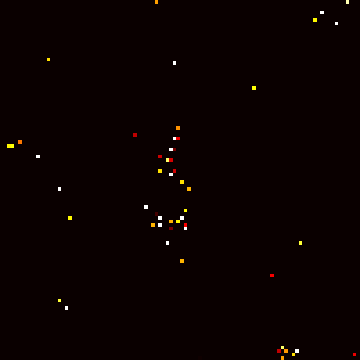
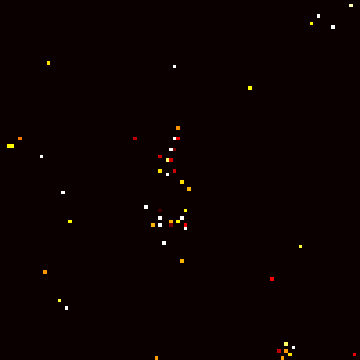
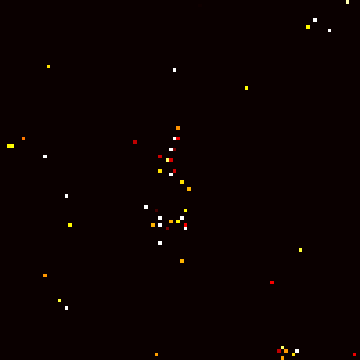
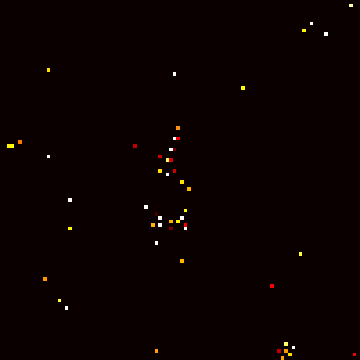
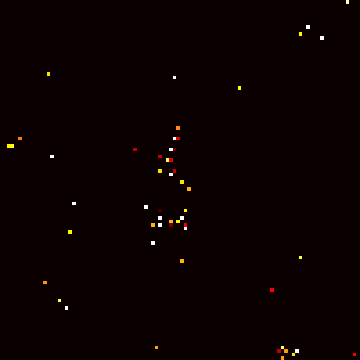
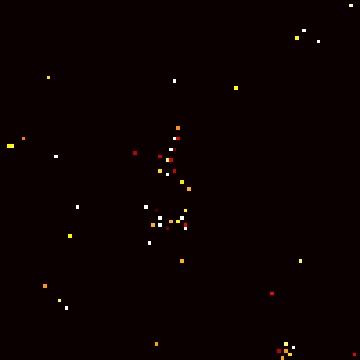
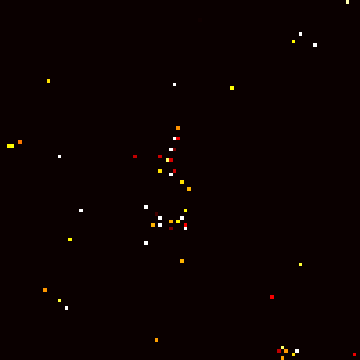
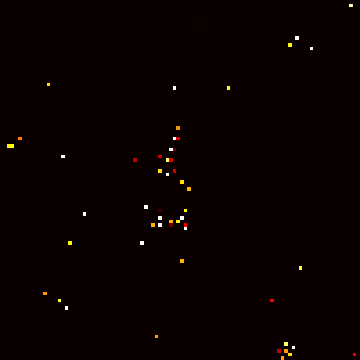
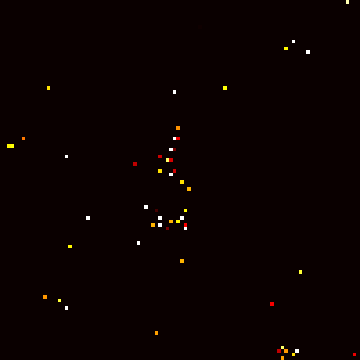
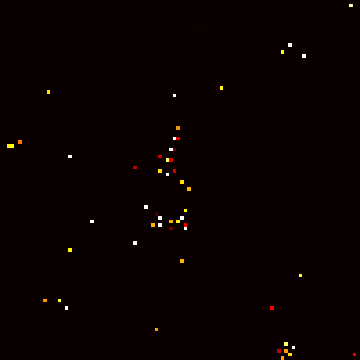
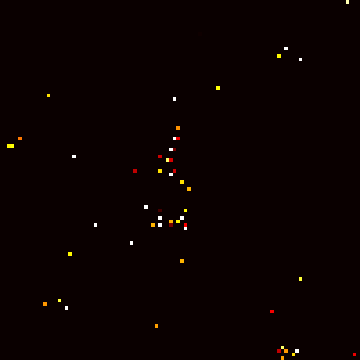
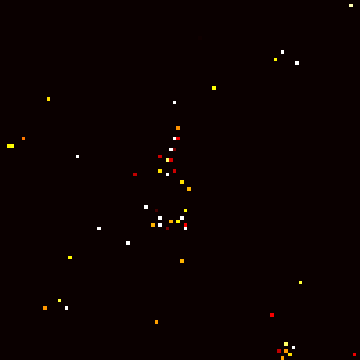
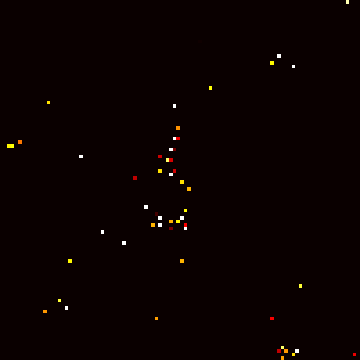
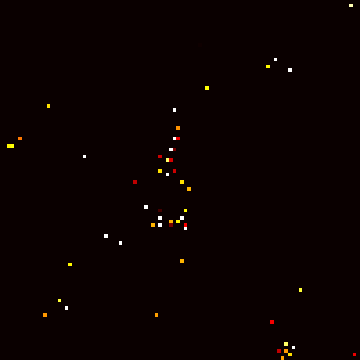
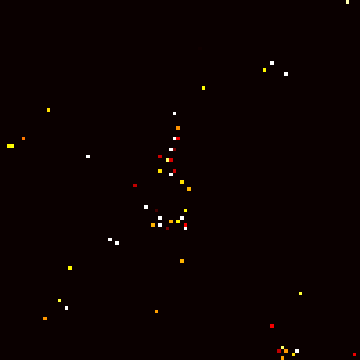
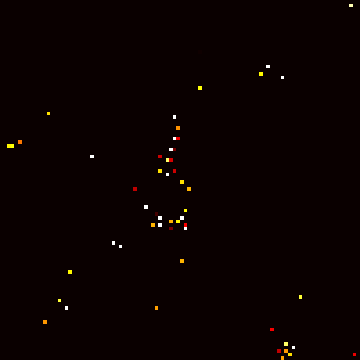
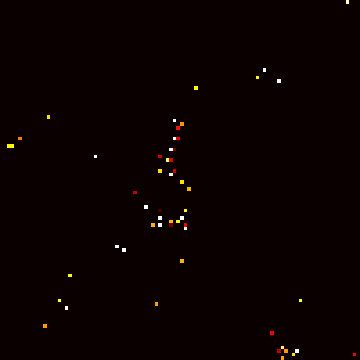
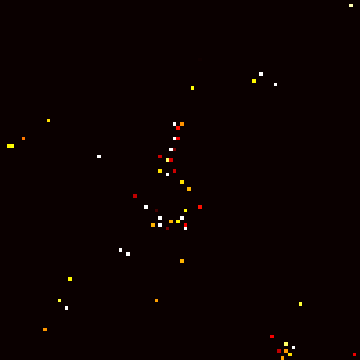
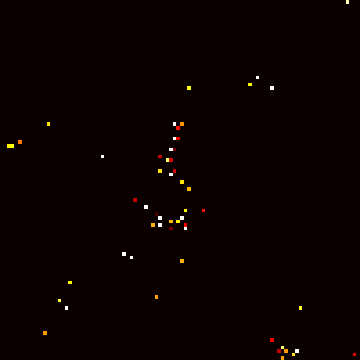
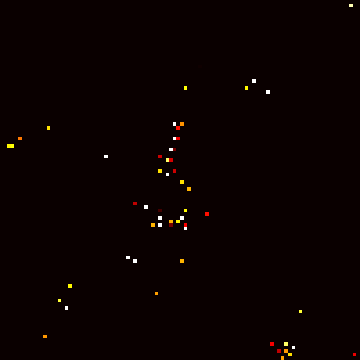
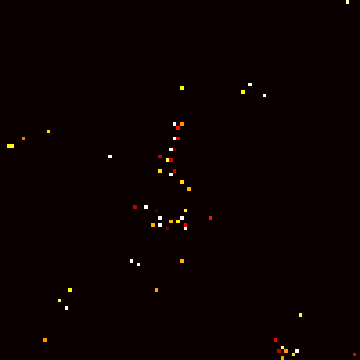
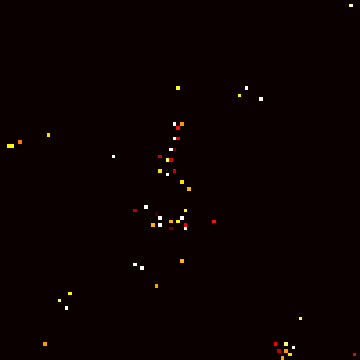
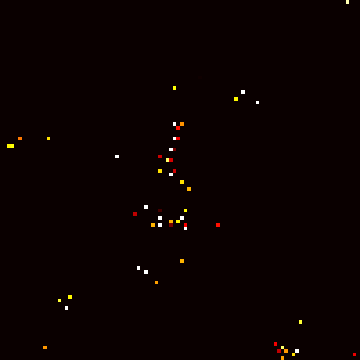
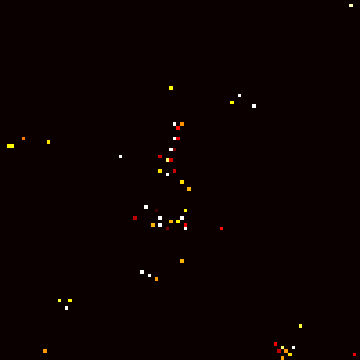
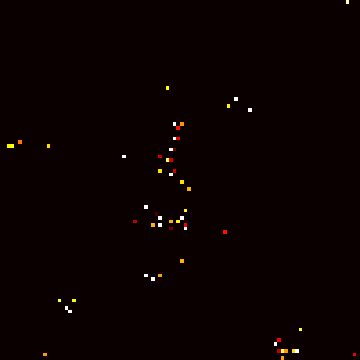
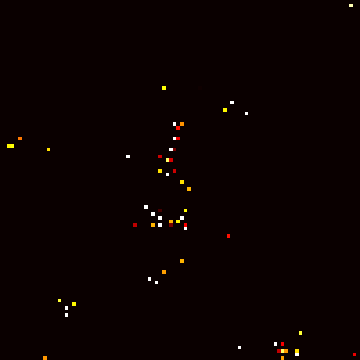
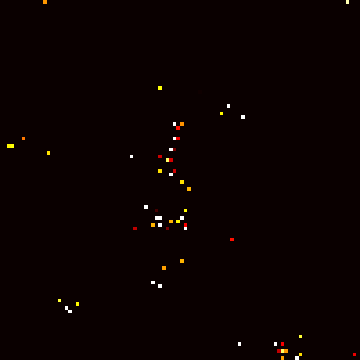
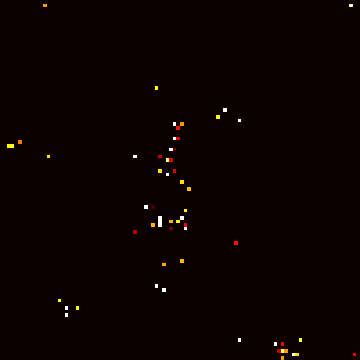
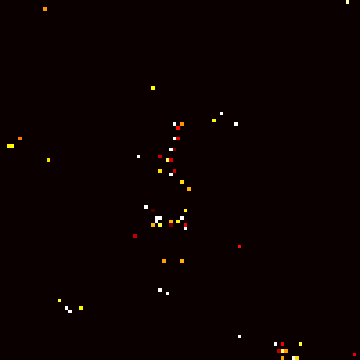
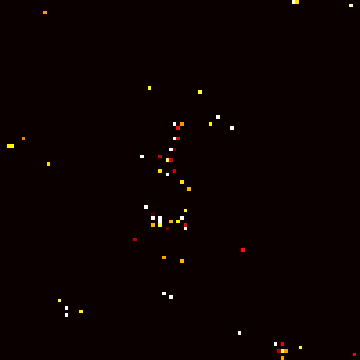
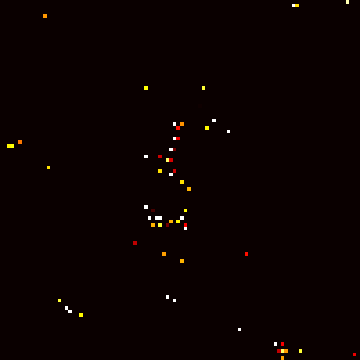
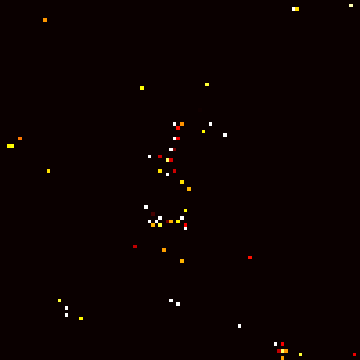
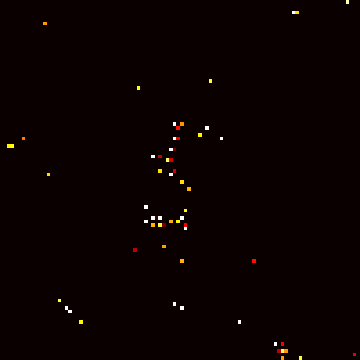
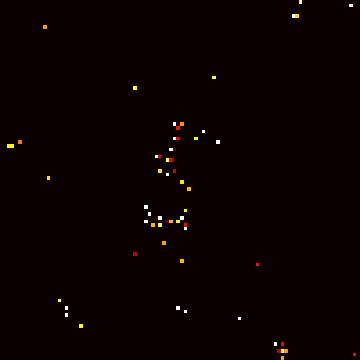

In [6]:
gr, c, cw, t, k = slime();gr

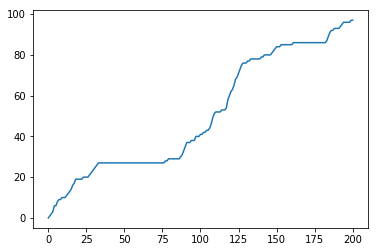

In [7]:
plt.plot(t[:,0],t[:,1])

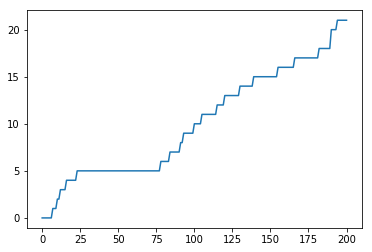

In [8]:
plt.plot(t[:,0],t[:,2])

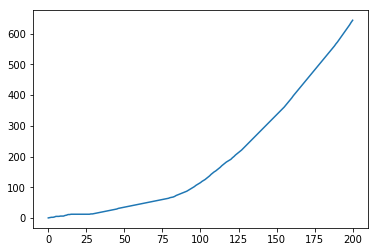

In [9]:
plt.plot(t[:,0],t[:,3])

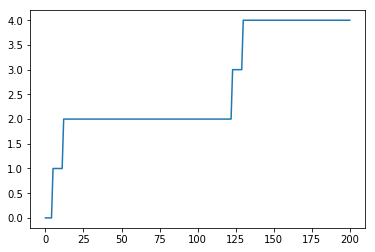

In [10]:
plt.plot(t[:,0],t[:,4])

In [11]:
#gr2, c2, cw2, t2, k2 = slime(extract_tribe(c, cw, [5]));gr2

In [12]:
k

array([23, 17,  5,  1])

In [13]:
t

array([[  0,   0,   0,   0,   0],
       [  1,   1,   0,   1,   0],
       [  2,   2,   0,   2,   0],
       ..., 
       [198,  96,  21, 629,   4],
       [199,  97,  21, 637,   4],
       [200,  97,  21, 644,   4]])